# Using a Neural Network as a Regularizer

### Here we will try to use a nn with two inputs: the image (blurry or not) and the projection (exact one)

In [103]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random
import h5py
import math
import torch.nn.functional as F
import scipy.io
import matplotlib.pyplot as plt

### First we will create the dataset to train our nn

We use our brain dataset, and we add random values to each pixel in order to blurry images. All the values add are summed to create our regulized norm we want to minimize

In [104]:
# First let's take a few images

number_brains_train = 100
brains = []
for i in range(1, 1+number_brains_train):
    with h5py.File('../../Brains/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains += [brain]

In [105]:
# Pojection Matrix

mat_90 = scipy.io.loadmat('../thinL64_90')
A_90 = mat_90['H'].todense()
print(A_90)
print(A_90.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(8100, 4096)


In [106]:
# Let's artificially blurry the images

resulting_brains = []
vars_ = []
projections_ = []


number_brains_blurried = 10

for l in range(len(brains)):
    test_brain = brains[l]/1000
    resulting_brains.append(test_brain)
    vars_.append(0)
    p_90 = np.transpose(np.matmul(A_90, test_brain.flatten()))
    projections_.append(p_90.reshape(90, 90))
    for i in range(number_brains_blurried):
        var = 0
        changed_brain = np.copy(test_brain)
        for j in range(64):
            for k in range(64):
                value = changed_brain[k][j]
                add = np.random.randint(max(-value, -1000+100*i), 1000-100*i)/1000
                #print(changed_brain[k][j])
                changed_brain[k][j] = value + add
                #print(changed_brain[k][j])

                var = var + add*add/1000
        resulting_brains.append(changed_brain)
        vars_.append(var)
        
        p_90 = np.transpose(np.matmul(A_90, test_brain.flatten()))
        projections_.append(p_90.reshape(90, 90))

In [107]:
def randomize(a, b, c):
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    shuffled_c = c[permutation]
    return shuffled_a, shuffled_b, shuffled_c

resulting_brains, vars_, projections_ = randomize(np.array(resulting_brains), np.array(vars_), np.array(projections_))

print(vars_[:10])

[0.220976   0.33959726 0.88549893 1.10067667 0.05419162 1.09024209
 0.05325891 0.86673066 0.01354697 0.67516498]


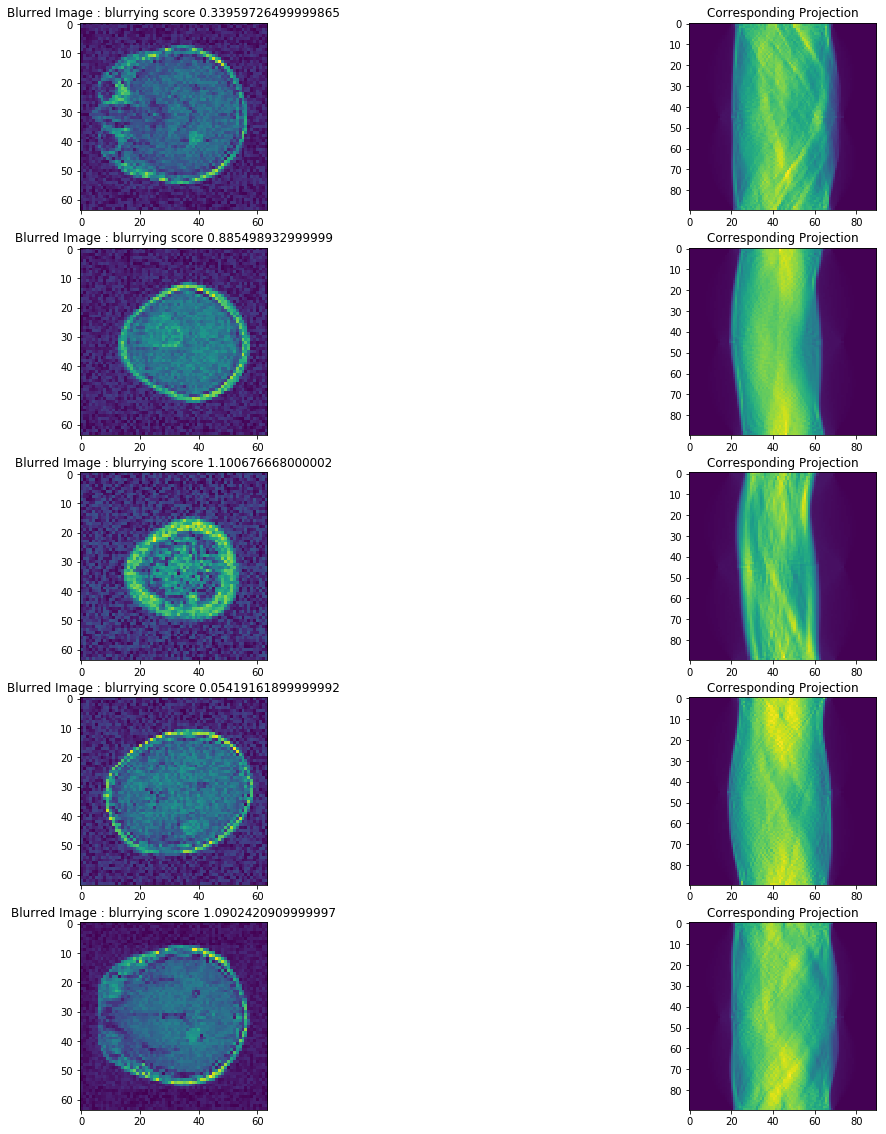

In [108]:
columns = 2
rows = 5

fig=plt.figure(figsize=(20, 20))
for i in range(1, 6):
    brain = resulting_brains[i-1]
    fig.add_subplot(rows, columns, 2*i-1)
    plt.title('Blurred Image : blurrying score ' + str(vars_[i]))
    plt.imshow(brain)
    
    P = projections_[i-1]
    fig.add_subplot(rows, columns, 2*i)
    plt.title('Corresponding Projection')
    plt.imshow(P)
    
plt.show()

Now that we have our data, let's build the network

In [109]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.features1 = nn.Sequential(
            nn.Conv2d(1, 3, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.features2 = nn.Sequential(
            nn.Conv2d(1, 3, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(45*45*3 + 32*32*3, 1)
        
    def forward(self, x1, x2):
        x1 = self.features1(x1)
#         print('SHAPE', x1.shape)
        x2 = self.features2(x2)
#         print('SHAPE', x2.shape)
        
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
#         print('SHAPE', x1.shape, x2.shape)
        x = torch.cat((x1, x2), dim=1)
#         print('SHAPE', x.shape)
        x = self.classifier(x)
        
        return x

In [110]:
# Hyperparameters
num_epochs = 2
num_classes = 10
batch_size = 1
learning_rate = 0.0001

In [111]:
model = ConvNet()

# Loss and optimizer

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [112]:
vars_ = np.array(vars_).reshape(number_brains_train*(number_brains_blurried+1), 1)
resulting_brains = np.array(resulting_brains).reshape(number_brains_train*(number_brains_blurried+1), 1, 64, 64)
projections_ = np.array(projections_).reshape(number_brains_train*(number_brains_blurried+1), 1, 90, 90)

print(vars_.shape[0], vars_.shape)

1100 (1100, 1)


In [113]:
# Train the model

total_step = vars_.shape[0]
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    
    for i in range(vars_.shape[0]):
        
        images = torch.from_numpy(resulting_brains[i].reshape(1, 1, 64, 64))
        images = Variable(images.float())
        
        projs = torch.from_numpy(projections_[i].reshape(1, 1, 90, 90))
        projs = Variable(projs.float())
        labels = torch.from_numpy(vars_[i])
        
        outputs = model(projs, images)
        loss = criterion(outputs, labels.float())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

#         # Track the accuracy
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/2], Step [100/1100], Loss: 0.0993
Epoch [1/2], Step [200/1100], Loss: 0.0580
Epoch [1/2], Step [300/1100], Loss: 0.0849
Epoch [1/2], Step [400/1100], Loss: 0.2544
Epoch [1/2], Step [500/1100], Loss: 0.0067
Epoch [1/2], Step [600/1100], Loss: 0.0414
Epoch [1/2], Step [700/1100], Loss: 0.0103
Epoch [1/2], Step [800/1100], Loss: 0.1086
Epoch [1/2], Step [900/1100], Loss: 0.0219
Epoch [1/2], Step [1000/1100], Loss: 0.0039
Epoch [1/2], Step [1100/1100], Loss: 0.1678
Epoch [2/2], Step [100/1100], Loss: 0.0319
Epoch [2/2], Step [200/1100], Loss: 0.0590
Epoch [2/2], Step [300/1100], Loss: 0.0419
Epoch [2/2], Step [400/1100], Loss: 0.0514
Epoch [2/2], Step [500/1100], Loss: 0.0131
Epoch [2/2], Step [600/1100], Loss: 0.0264
Epoch [2/2], Step [700/1100], Loss: 0.0307
Epoch [2/2], Step [800/1100], Loss: 0.0825
Epoch [2/2], Step [900/1100], Loss: 0.0001
Epoch [2/2], Step [1000/1100], Loss: 0.0083
Epoch [2/2], Step [1100/1100], Loss: 0.0157


In [114]:
# Testing 

resulting_brains_test = []
vars_test= []

brains_test = []
for i in range(len(brains), len(brains)+10):
    with h5py.File('../Brains/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains_test += [brain]

for l in range(len(brains_test)):
    test_brain = brains_test[l]/1000
    resulting_brains_test.append(test_brain)
    vars_test.append(0)
    for i in range(10):
        var = 0
        changed_brain = np.copy(test_brain)
        for j in range(64):
            for k in range(64):
                value = changed_brain[k][j]
                add = np.random.randint(max(-value, -1000+100*i), 1000-100*i)/1000
                changed_brain[k][j] = value + add

                var = var + add*add/1000
        resulting_brains_test.append(changed_brain)
        vars_test.append(var)


OSError: Unable to open file (unable to open file: name = '../Brains/100.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)